In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.stats import uniform
import sklearn.mixture as mixture_model
from scipy.optimize import minimize
from scipy.stats import multivariate_normal as normal

from scipy.optimize import approx_fprime
import scipy.optimize as op

import matplotlib.patches as patches

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from pylab import *
import shutil
import sys
import os.path
from pyomo.environ import *

In [2]:
from dprae_functions import gmm_model, gmm_pdf
from dprae_nn import model, trainer

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def sigmoid(x):
    return np.divide(np.exp(x) , 1 + np.exp(x))

def g(x, theta, c, gamma=0):
    g0 = theta[0]*sigmoid(x-gamma-c[0])
    g1 = theta[1]*sigmoid(x-gamma-c[1])
    g2 = theta[2]*sigmoid(x-gamma-c[2])
    g3 = theta[3]*sigmoid(x-gamma-c[3])
    y_out = np.abs(g0 + g1 + g2 + g3).sum(axis=1)
    return y_out

def f(x, theta, c, gamma=0, thres=1.8):
    g_values = g(x, theta, c, gamma)
    return g_values > thres

In [4]:
# set rare event set params
theta=[-1, 0.2, -0.6, 0.2]
c = [3, 7, 8, 6]

# set naturalistic distribution p
mu_0 = [5, 5]
sigma_0 = 0.25*np.eye(2)
p = normal(mu_0, sigma_0)

# space bounds
lb=0
ub=10

# initiate grids over the space bounds
x1_grid = np.linspace(lb, ub, 200)
x2_grid = np.linspace(lb, ub, 200)
x1s, x2s = np.meshgrid(x1_grid, x2_grid)
xs = np.array([x1s.reshape(-1), x2s.reshape(-1)]).transpose()
ps = p.pdf(xs).reshape(x1s.shape)

# set rarity params
gammas = np.linspace(0, 2.6, 14)

In [5]:
def cutting_plane(x, eq, eps=1e-5, rad=1):
    m = approx_fprime(x, eq, eps)
    c =  -np.dot(x, m) 
    hp = lambda xx: (-np.dot(xx, m)-c) - rad
    return hp

def dp_halfspace(mu, mu_0, sigma_0, rad=1e-3):
    hp = lambda x:  np.dot(np.dot((mu-mu_0), np.linalg.inv(sigma_0)) , (x-mu).transpose()) - rad
    return hp

In [6]:
def objective(X):
    x = X
    Mu = mu_0
    
    Sigma = sigma_0
    obj = np.matmul(np.matmul((x-Mu),np.linalg.inv(Sigma)),np.transpose(x-Mu)).item()
    return obj

def eq(X):
    x = X
    g = lambda xx: np.diff(model_net(torch.Tensor(xx).to(device)).cpu().data.numpy(), axis=1)
    return (g(x.reshape(1,2)).item())

def cons_generator(xstar, eq_cons, dim=2):
    Mus = xstar.reshape(-1, dim)
    Sigma = np.eye(dim)
    
    N = Mus.shape[0]
    ineq_const = eq_cons
    
    Mu = Mus[-1,:]
    ineq_i = cutting_plane(Mu, eq)
    #ineq_i = dp_halfspace(Mu, mu_0, sigma_0, rad=1e-3)
   
    cons_new = {'type':'ineq', 'fun': ineq_i}            
    ineq_const.append(dict(cons_new))
        
    return ineq_const

In [7]:
def extreme_points(X, Y, K_lim = 1e3):
    flag_1 = (Y==0).reshape([-1,])
    flag_2 = X[:,0] >= 0
    flag_3 = X[:,1] >= 0

    x_non_dom = X[np.logical_and(np.logical_and(flag_1, flag_2), flag_3),:]
    ortho_g_i_set = []
    [N, dim] = X.shape
    x_orig = np.zeros([dim, 1])
    k=0
    x_doms = []
    iterating = True

    while iterating:
        if k >= K_lim:
            iterating = False
        else:
            id_dom = p.pdf(x_non_dom).argmin()
            x_dom = x_non_dom[id_dom, :]
            x_doms.append(x_dom)
            flag_dom = np.zeros(x_non_dom.shape).astype('int')
            
            for d in range(dim):
                flag_dom[:, d] = x_non_dom[:, d] <= x_dom[d]

            flag_dom = np.all(flag_dom, axis=1)

            if flag_dom.sum() >= x_non_dom.shape[0]:
                iterating = False
            else:
                x_non_dom = x_non_dom[~flag_dom,:]

        k = k+1
    return np.array(x_doms)


def ortho_convhul_predict(X, x_ext, eps = 1e-6):
    x_ext_tile = x_ext.transpose().reshape(1, 2, -1)
    X_tile = np.repeat(X[:, :, np.newaxis], x_ext.shape[0], axis=2)

    Y_hat = np.any(np.all(x_ext_tile - X_tile >= eps, axis=1), axis=1)
    return ~Y_hat



def draw_ortho_conv_hull(x_ext, ref=[0, 0], mode=0):
    for i in range(x_ext.shape[0]):
        if mode == 0:
            rc_i = patches.Rectangle(ref, x_ext[i, 0], x_ext[i, 1], color='C0')
        else:
            rc_i = patches.Rectangle([x_ext[i, 0], x_ext[i, 1]], ref[0]-x_ext[i, 0], ref[1]-x_ext[i, 1], color='C3')
        plt.gca().add_patch(rc_i)



In [8]:
def extreme_points_lb(X, Y, K_lim = 1e3):
    flag_1 = (Y==1).reshape([-1,])
    flag_2 = X[:,0] >= 0
    flag_3 = X[:,1] >= 0

    x_non_dom = X[np.logical_and(np.logical_and(flag_1, flag_2), flag_3),:]
    ortho_g_i_set = []
    [N, dim] = X.shape
    x_orig = np.zeros([dim, 1])
    k=0
    x_doms = []
    iterating = True

    while iterating:
        if k >= K_lim:
            iterating = False
        else:

            id_dom = p.pdf(x_non_dom).argmax()

            x_dom = x_non_dom[id_dom, :]
            x_doms.append(x_dom)
            
            #filter
            flag_dom = np.zeros(x_non_dom.shape).astype('int')
            for d in range(dim):
                flag_dom[:, d] = x_non_dom[:, d] >= x_dom[d]

            flag_dom = np.all(flag_dom, axis=1)

            if flag_dom.sum() >= x_non_dom.shape[0]:
                iterating = False
            else:
                x_non_dom = x_non_dom[~flag_dom,:]
        k = k+1

    return np.array(x_doms)


def ortho_convhul_predict_lb(X, x_ext, eps = 1e-6):
    x_ext_tile = x_ext.transpose().reshape(1, 2, -1)
    X_tile = np.repeat(X[:, :, np.newaxis], x_ext.shape[0], axis=2)

    Y_hat = np.any(np.all(X_tile-x_ext_tile >= eps, axis=1), axis=1)
    return Y_hat

In [6]:
def mip_convhull_checking(x_ext):
    #MIP formulation solver
    mip_model = AbstractModel()

    # For a single layer NN
    mip_model.numofinputs = Param(within=NonNegativeIntegers)
    mip_model.numofhiddenlayers = Param(within=NonNegativeIntegers)
    mip_model.gamma = Param(within=Reals)
    mip_model.numofX = Param(within=NonNegativeIntegers)

    mip_model.I = RangeSet(1, mip_model.numofinputs)
    mip_model.J = RangeSet(1, mip_model.numofhiddenlayers)
    mip_model.K = RangeSet(1, mip_model.numofX)

    mip_model.A1 = Param(mip_model.J, mip_model.I, within=Reals)
    mip_model.B1 = Param(mip_model.J, within=Reals)
    mip_model.A2 = Param(mip_model.I, mip_model.J, within=Reals)
    mip_model.B2 = Param(mip_model.I, within=Reals)
    mip_model.M = Param(within=NonNegativeReals)
    mip_model.sgn = Param(mip_model.I, within=Reals)

    mip_model.X_hull = Param(mip_model.K, mip_model.I, within=Reals)

    mip_model.x = Var(mip_model.I, domain=NonNegativeReals)
    mip_model.y = Var(mip_model.J, domain=Reals)
    mip_model.z = Var(mip_model.J, domain=Binary)
    mip_model.zz = Var(mip_model.K, mip_model.I, domain=Binary)
    mip_model.beta = Var(domain=Reals)

    # Define the objective function
    def obj_function(mip_model):
        return -mip_model.beta
    mip_model.obj = Objective(rule=obj_function)

    # Define the dominating point constraints as a list
    def constraint1(mip_model, i, j):
        return (mip_model.x[j] - mip_model.X_hull[i,j] + 4*mip_model.M*(1-mip_model.zz[i,j]) >= mip_model.beta)
    mip_model.cons1 = Constraint(mip_model.K, mip_model.I, rule=constraint1)

    def constraint2(mip_model, i):
        return sum(mip_model.zz[i,j] for j in mip_model.I) >= 1
    mip_model.cons2 = Constraint(mip_model.K, rule=constraint2)

    # Define the NN constraints
    def relu_constraint1(mip_model, i):
        return sum(mip_model.A1[i,j] * mip_model.x[j] for j in mip_model.I) + mip_model.B1[i] + mip_model.M*(1-mip_model.z[i]) >= mip_model.y[i]
    mip_model.relu1 = Constraint(mip_model.J, rule=relu_constraint1)

    def relu_constraint2(mip_model, i):
        return sum(mip_model.A1[i,j] * mip_model.x[j] for j in mip_model.I) + mip_model.B1[i] <= mip_model.y[i]
    mip_model.relu2 = Constraint(mip_model.J, rule=relu_constraint2)

    def relu_constraint3(mip_model, i):
        return mip_model.M*model.z[i] >= mip_model.y[i]
    mip_model.relu3 = Constraint(mip_model.J, rule=relu_constraint3)

    def relu_constraint4(mip_model, i):
        return 0 <= mip_model.y[i]
    mip_model.relu4 = Constraint(mip_model.J, rule=relu_constraint4)

    def g_constraint(mip_model):
        return sum((sum(model.A2[i,j] * mip_model.y[j] for j in mip_model.J) + mip_model.B2[i])*mip_model.sgn[i] for i in mip_model.I) - mip_model.gamma >= 0
    mip_model.g_cons = Constraint(rule=g_constraint)


    numofextremepts = len(x_ext)
    data = {None: {
        'numofinputs': {None: input_dim},
        'numofhiddenlayers': {None: hidden_dim},
        'gamma': {None: gam},
        'numofX': {None: numofextremepts},
        'M':{None: 100000},
        'A1': {(i,j): A1[i-1][j-1] for i in range(1,hidden_dim+1) for j in range(1,input_dim+1)},
        'B1': {i: B1[i-1] for i in range(1,hidden_dim+1)},
        'A2': {(i,j): A2[i-1][j-1] for i in range(1,output_dim+1) for j in range(1,hidden_dim+1)},
        'B2': {i: B2[i-1] for i in range(1,output_dim+1)},
        'X_hull': {(i,j): x_ext[i-1][j-1] for i in range(1,numofextremepts+1) for j in range(1,input_dim+1)},
        'sgn': {i: signs[i-1] for i in range(1,output_dim+1)}
    }}

    instance = model.create_instance(data)
    solver = SolverFactory('gurobi')
    result = solver.solve(instance)
    instance.solutions.store_to(result)
    
    return result

In [9]:
def plot_exp_setting():
    plt.figure(figsize=(5, 5))

    plt.contourf(x1s, x2s, ys, levels=[-1, 0, 1], cmap="coolwarm")

    plt.rcParams["font.size"] = 18
    plt.scatter(mu_0[0], mu_0[1], c="k", label="$\mu_0$")
    plt.contour(x1s, x2s, ps, cmap="coolwarm")
    
    ## NN boundary
    plt.contour(x1s, x2s, g_s_ub, levels=[-1000, gamma_ub, 1000],  colors='w',  alpha=0.8)
    plt.contour(x1s, x2s, g_s_lb, levels=[-1000, gamma_lb, 1000],   colors='w', alpha=0.8)
    
    #LL boundary
    plt.contour(x1s, x2s, g_s_ll_ub, levels=[-1000, gamma_lb, 1000],  colors='k', alpha=0.8)
    plt.contour(x1s, x2s, g_s_ll_lb, levels=[-1000, gamma_lb, 1000],  colors='k', alpha=0.8)
    plt.text(1, 9.3, '$\gamma$={0:0.1f}'.format(gamma_prob))
    
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.xlim(lb, ub)
    plt.ylim(lb, ub)
    plt.show()

In [10]:
def ll_dominant_point(X, Y):    
    print('Initialize ll')
    flag_first_quadr = np.logical_and(X[:, 0] > 0, X[:, 1] > 0)
    flag_positive = Y == 1
    flag_filter = np.logical_and(flag_first_quadr, flag_positive)

    X_pool = X[flag_filter,:]#limit to first quadrant rare
    Y_pool = Y[flag_filter]
    idx = p.pdf(X_pool).argmax()

    rad_i = 1e-12
    x_i_star = X_pool[idx, :]
    g_i = dp_halfspace(x_i_star, mu_0, sigma_0, rad=1e-3)
    flag_g_i = g_i(X_pool) + rad_i < 0
    X_pool = X_pool[flag_g_i,:]
    Y_pool = Y_pool[flag_g_i]
    xstar_ll = x_i_star.reshape(-1, 2)

    print('Start Iterate for ll')

    #iterate
    icp_iterate = True
    while icp_iterate:

        if X_pool.size:
            idx = p.pdf(X_pool).argmax()
            x_i_star = X_pool[idx, :]
            xstar_ll = np.append(xstar_ll, x_i_star).reshape(-1, 2)

            g_i = dp_halfspace(x_i_star, mu_0, sigma_0, rad=0) # g_i <= 0 means dangerous        

            flag_g_i = g_i(X_pool) + rad_i < 0
            X_pool = X_pool[flag_g_i,:]
            Y_pool = Y_pool[flag_g_i]
        else: 
            icp_iterate = False
         
    return xstar_ll

def get_extreme_points(X, Y, num_last=10000, K_lim=1e4):
    X_k = X[0:num_last, :]
    Y_k = Y[0:num_last]
    x_ext = extreme_points(X_k, Y_k, K_lim = 1e5)
    x_lb_ext = extreme_points_lb(X_k, Y_k, K_lim = 1e3)
    
    return x_ext, x_lb_ext


def gmm_is_proposal(xstar_ll, sigma_0):
    n_mixtures = np.array(xstar_ll).shape[0]
    sigmas = sigma_0[0, 0]*np.ones([n_mixtures, 1])
    weights = np.ones([n_mixtures, 1])/n_mixtures

    gmm_q = gmm_model(xstar_ll, n_mixtures, xs, sigmas, weights)
    gmm_q_values = gmm_pdf(xs, gmm_q).reshape(x1s.shape)
    
    return gmm_q, gmm_q_values

def kappa_hat_tuning_ub(X_tuning, x_ext, ghat, max_iter_dprae, tolerance=0):
    num_iter_dprae = 0
    iter_dprae = True
    
    gamma_ub = 30
    d_gamma = 1
        
    #print("Tuning UB")

    while iter_dprae:   
        Yhat_1 = (ghat(X_tuning) > gamma_ub).reshape(-1, )
        Yhat_2 = ortho_convhul_predict(X_tuning, x_ext)
        fn_rate_ub = ( Yhat_1< Yhat_2).sum()

        if fn_rate_ub <= tolerance:
            iter_dprae = False
        else:
            gamma_ub = gamma_ub - d_gamma
            
        if num_iter_dprae >= max_iter_dprae:
            iter_dprae = False
            
        num_iter_dprae = num_iter_dprae+1
        
    return gamma_ub

def kappa_hat_tuning(X_tuning, gamma_0, d_gamma, x_ext, ghat, max_iter_dprae, bound_type, tolerance=0):
    num_iter_dprae = 0
    iter_dprae = True
    
    gamma_out = gamma_0
    
    while iter_dprae:   
        Yhat_1 = (ghat(X_tuning) > gamma_out).reshape(-1, )
        
        if bound_type=="lb":
            Yhat_2 = ortho_convhul_predict_lb(X_tuning, x_ext)
            fn_rate = ( Yhat_1 > Yhat_2).sum()   
        else:            
            Yhat_2 = ortho_convhul_predict(X_tuning, x_ext) #sign flipped with ~
            fn_rate = ( Yhat_1 < Yhat_2).sum()   
        
        if fn_rate <= tolerance:
            iter_dprae = False
        else:
            gamma_out = gamma_out+d_gamma
            
        if num_iter_dprae >= max_iter_dprae:
            iter_dprae = False
            
        num_iter_dprae = num_iter_dprae+1
        
    return gamma_out

In [11]:
def dprae_dominant_point(X, Y, p, dim=2, num_iters=500):
    eq_cons = [{'type': 'ineq', 'fun': eq}]

    # solve first time with randomized starting point
    x0 = mu_0
    sol = minimize(objective, x0, method='COBYLA', constraints=eq_cons)
    
    if sol.status >=1:
        x0 = sol.x
        xstar = sol.x.reshape(-1, dim)
        cons = cons_generator(xstar, eq_cons)
    
    np.random.seed(0)
    x0_trials = p.rvs(num_iters)

    #iterate
    for it in range(num_iters):
        
        # re-solve
        sol = minimize(objective, x0, method='COBYLA', constraints=cons)

        # check status
        if (sol.status ==1)*(eq(sol.x)<0) :            
            xstar = np.append(xstar, sol.x).reshape(-1, 2)

            #generate constraints
            cons = cons_generator(xstar, eq_cons)

            #restart to mu
            x0 = sol.x

        else:
            x0 = x0_trials[it,:]
            
    return xstar


In [12]:
def ce_valid(samples, ub):
    flag = np.logical_and(samples>0,  samples<ub).all(axis=1)
    return flag

def ce_iter(mu_it, t_it, mu_0, sigma, N, ub, is_plot=False):
    temp=normal(mu_it,sigma).rvs(10*N)
    ok_samples=temp[ce_valid(temp, ub),:]

    stage2_samples=ok_samples[1:N,:]
    in_rare_ind=f(stage2_samples,theta, c, t_it)
    
    c_it=np.divide(np.multiply(in_rare_ind, normal(mu_0,sigma).pdf(stage2_samples)), normal(mu_it, sigma).pdf(stage2_samples))
    a_it = np.multiply(np.tile(c_it, (2, 1)).transpose(), stage2_samples).sum(axis=0)/c_it.sum()
    
    if is_plot:
        plot_ce_iter_final(stage2_samples, in_rare_ind, a_it, t_it, ub, lb)
    
    return a_it

def plot_ce_iter_final(stage2_samples, in_rare_ind, a_it, t_it, ub, lb):
    ys = (f(xs, theta, c, t_it)).reshape(x1s.shape)
    
    plt.figure(figsize=[5, 5])
    plt.rcParams["font.size"] = 24
    
    plt.contourf(x1s, x2s, ys, levels=[-100, 0, 100], cmap="coolwarm")
    
    plt.scatter(a_it[0],a_it[1],marker='x', c="k", s=50)
    plt.xlim([lb, ub])
    plt.ylim([lb, ub])
    plt.show()


Initialize ll
Start Iterate for ll
LL mixture
D-PrAE kappa tuning
Tuning kappa done
D-PrAE mixture
CE iter
Generate plot


/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: No contour levels were found within the data range.
  app.launch_new_instance()
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: No contour levels were found within the data range.


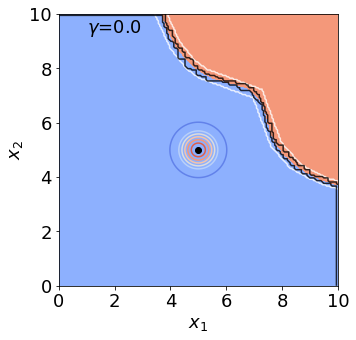

Start evaluating
Initialize ll
Start Iterate for ll
LL mixture
D-PrAE kappa tuning
Tuning kappa done
D-PrAE mixture
CE iter
Generate plot


/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: No contour levels were found within the data range.
  app.launch_new_instance()
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: No contour levels were found within the data range.


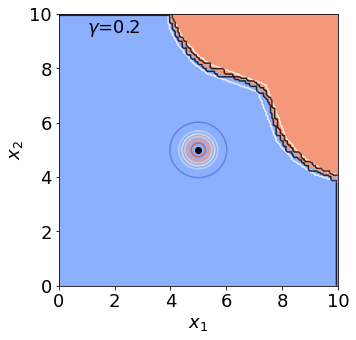

Start evaluating
Initialize ll
Start Iterate for ll
LL mixture
D-PrAE kappa tuning
Tuning kappa done
D-PrAE mixture
CE iter
Generate plot


/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: No contour levels were found within the data range.
  app.launch_new_instance()
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: No contour levels were found within the data range.


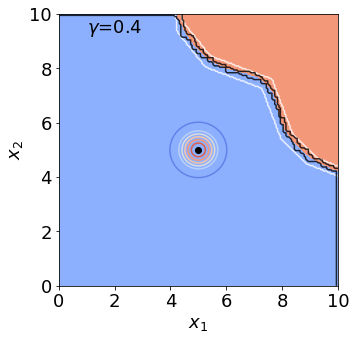

Start evaluating
Initialize ll
Start Iterate for ll
LL mixture
D-PrAE kappa tuning
Tuning kappa done
D-PrAE mixture
CE iter
Generate plot


/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: No contour levels were found within the data range.
  app.launch_new_instance()
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: No contour levels were found within the data range.


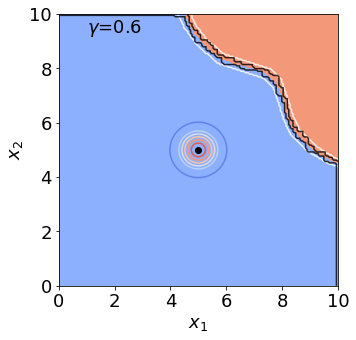

Start evaluating
Initialize ll
Start Iterate for ll
LL mixture
D-PrAE kappa tuning
Tuning kappa done
D-PrAE mixture
CE iter
Generate plot


/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: No contour levels were found within the data range.
  app.launch_new_instance()
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: No contour levels were found within the data range.


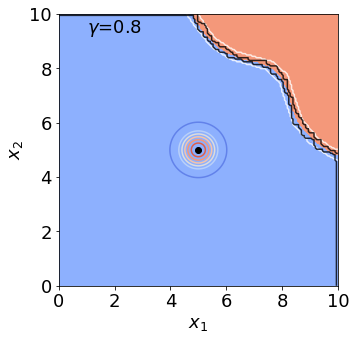

Start evaluating
Initialize ll
Start Iterate for ll
LL mixture
D-PrAE kappa tuning
Tuning kappa done
D-PrAE mixture
CE iter
Generate plot


/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: No contour levels were found within the data range.
  app.launch_new_instance()
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: No contour levels were found within the data range.


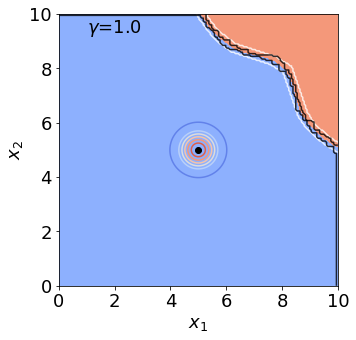

Start evaluating
Initialize ll
Start Iterate for ll
LL mixture
D-PrAE kappa tuning
Tuning kappa done
D-PrAE mixture
CE iter
Generate plot


/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: No contour levels were found within the data range.
  app.launch_new_instance()
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: No contour levels were found within the data range.


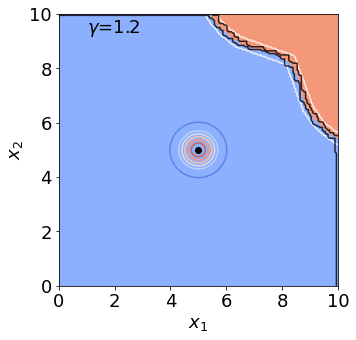

Start evaluating
Initialize ll
Start Iterate for ll
LL mixture
D-PrAE kappa tuning
Tuning kappa done
D-PrAE mixture
CE iter
Generate plot


/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: No contour levels were found within the data range.
  app.launch_new_instance()
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: No contour levels were found within the data range.


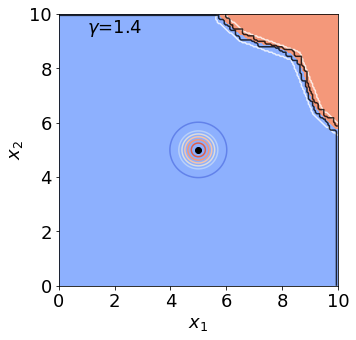

Start evaluating
Initialize ll
Start Iterate for ll
LL mixture
D-PrAE kappa tuning
Tuning kappa done
D-PrAE mixture
CE iter
Generate plot


/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: No contour levels were found within the data range.
  app.launch_new_instance()
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: No contour levels were found within the data range.


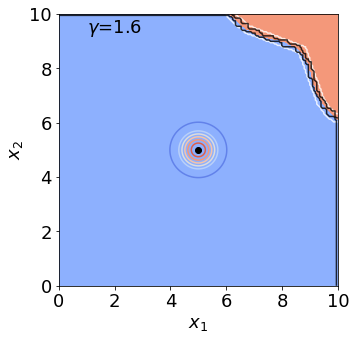

Start evaluating
Initialize ll
Start Iterate for ll
LL mixture
D-PrAE kappa tuning
Tuning kappa done
D-PrAE mixture
CE iter
Generate plot


/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: No contour levels were found within the data range.
  app.launch_new_instance()
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: No contour levels were found within the data range.


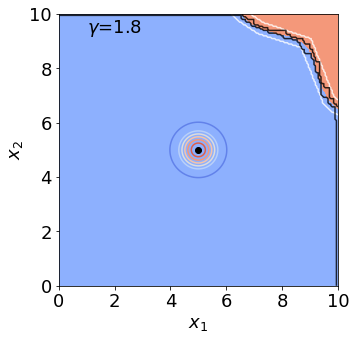

Start evaluating
Initialize ll
Start Iterate for ll
LL mixture
D-PrAE kappa tuning
Tuning kappa done
D-PrAE mixture
CE iter
Generate plot


/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: No contour levels were found within the data range.
  app.launch_new_instance()
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: No contour levels were found within the data range.


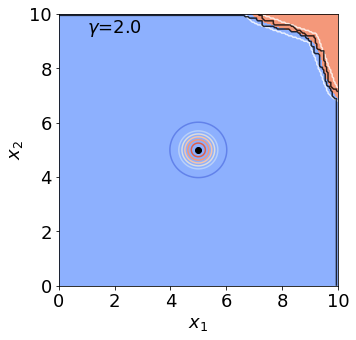

Start evaluating
Initialize ll
Start Iterate for ll
LL mixture
D-PrAE kappa tuning
Tuning kappa done
D-PrAE mixture
CE iter
Generate plot


/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: No contour levels were found within the data range.
  app.launch_new_instance()
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: No contour levels were found within the data range.


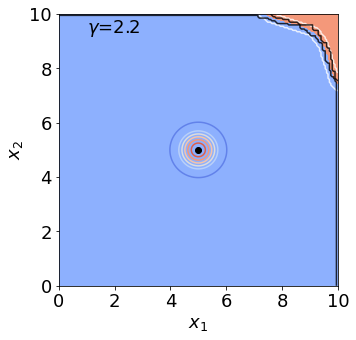

Start evaluating
Initialize ll
Start Iterate for ll
LL mixture
D-PrAE kappa tuning
Tuning kappa done
D-PrAE mixture
CE iter
Generate plot


/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: No contour levels were found within the data range.
  app.launch_new_instance()
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: No contour levels were found within the data range.


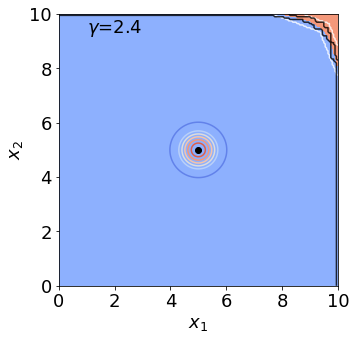

Start evaluating
Initialize ll
Start Iterate for ll
LL mixture
D-PrAE kappa tuning
Tuning kappa done
D-PrAE mixture
CE iter
Generate plot


/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: No contour levels were found within the data range.
  app.launch_new_instance()
/home/mansur/Mansur/Research/deep_is/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: No contour levels were found within the data range.


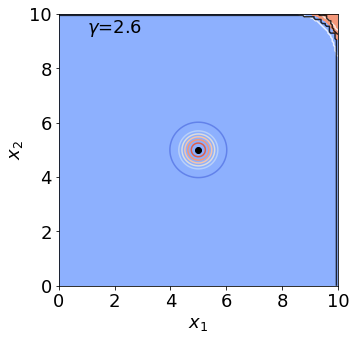

Start evaluating


In [15]:
np.random.seed(2020)

results_exp = []
result_it=[]

k=100000
N= 10000
input_dim = 2
hidden_dim = 32
output_dim = 2

for it_exp in range(gammas.shape[0]):
    gamma_prob = gammas[it_exp]    
    X = uniform(lb, ub).rvs([N, 2])
    Y=f(X, theta, c, gamma = gamma_prob)
    ys = f(xs, theta, c, gamma=gamma_prob).reshape(x1s.shape)    
    
    PATH = "net_nonstd_exp_gammavar_{}".format(it_exp)
    net = model(input_dim, hidden_dim, output_dim).to(device)
    net.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
    
    
    model_net= net
    ghat = lambda x: np.diff(model_net(torch.Tensor(x).to(device)).cpu().data.numpy(), axis=1)
    
    #Lazy Learner
    X = uniform(0, ub).rvs([N, 2])
    Y=f(X, theta, c, gamma = gamma_prob)
    xstar_ll = ll_dominant_point(X, Y)
    
    num_last = 10000
    x_ext, x_lb_ext = get_extreme_points(X, Y, num_last)
        
    print("LL mixture")
    q_ll, qs_ll = gmm_is_proposal(xstar_ll, sigma_0)

    
    #D-PrAE
    print("D-PrAE kappa tuning")    
    not_close_on_bound = np.logical_and((X>lb+0.1).all(axis=1),(X<ub-0.1).all(axis=1))
    X_tuning = X[not_close_on_bound ,: ]
    Y_tuning = Y[not_close_on_bound]

    max_iter_dprae_tuning = 100
    gamma_ub = kappa_hat_tuning(X_tuning, 30, -1, x_ext, ghat, max_iter_dprae_tuning, bound_type="ub", tolerance=0)
    gamma_lb = kappa_hat_tuning(X_tuning, -30, 0.5, x_lb_ext, ghat, max_iter_dprae_tuning, bound_type="lb", tolerance=0)        
    print("Tuning kappa done")   
    
    xstar = dprae_dominant_point(X, Y, p, dim=2, num_iters=500)
    
    print("D-PrAE mixture")
    q, qs = gmm_is_proposal(xstar, sigma_0)    
    
    
    print('CE iter')    
    num_it_ce=30
    gamma_ces = np.linspace(-1, gamma_prob, num_it_ce)
    a_it = mu_0
    
    for tnow in range(num_it_ce):
        t_it = gamma_ces[tnow]
        a_now = ce_iter(a_it, t_it, mu_0, sigma_0, 1000, ub)    
        a_it = a_now
      
    q_ce = normal(a_it, 0.5*sigma_0*np.eye(2))
    
    print("Generate plot")
    g_s_ub = (ghat(xs) >= gamma_ub).reshape(x1s.shape)
    g_s_lb = (ghat(xs) >= gamma_lb).reshape(x1s.shape)
    g_s_ll_ub = ortho_convhul_predict(xs, x_ext).reshape(x1s.shape)
    g_s_ll_lb = ortho_convhul_predict_lb(xs, x_lb_ext).reshape(x1s.shape)
    
    plot_exp_setting()
    
    print("Start evaluating")
    
    K=10
    d = 2

    ns = np.array([20000])

    mus_mc = np.zeros(ns.shape)
    var_mus_mc = np.zeros(ns.shape)

    mus_is = np.zeros(ns.shape)
    var_mus_is = np.zeros(ns.shape)

    mus_is_ub = np.zeros(ns.shape)
    var_mus_is_ub = np.zeros(ns.shape)

    mus_is_lb = np.zeros(ns.shape)
    var_mus_is_lb = np.zeros(ns.shape)

    mus_is_ll = np.zeros(ns.shape)
    var_mus_is_ll = np.zeros(ns.shape)

    mus_is_ll_ub = np.zeros(ns.shape)
    var_mus_is_ll_ub = np.zeros(ns.shape)

    mus_is_ll_lb = np.zeros(ns.shape)
    var_mus_is_ll_lb = np.zeros(ns.shape)
    
    mus_ce = np.zeros(ns.shape)
    var_mus_ce = np.zeros(ns.shape)

    i=0
    for n in ns:
        mu_mc = np.zeros(K)
        mu_is = np.zeros(K)
        mu_ce = np.zeros(K)
        mu_is_ub = np.zeros(K)
        mu_is_lb = np.zeros(K)

        mu_is_ll = np.zeros(K)
        mu_is_ll_ub = np.zeros(K)
        mu_is_ll_lb = np.zeros(K)

        for k in range(K):
            #MC
            X_p = p.rvs(n + N)
            Y_p = f(X_p, theta, c, gamma = gamma_prob)
            mu_mc[k] = Y_p.mean(axis=0)
            
            #CE
            X_c = q_ce.rvs(n)
            W = np.divide(p.pdf(X_c), q_ce.pdf(X_c))
            Y_c = f(X_c, theta, c, gamma = gamma_prob)
            mu_ce[k] = np.multiply(Y_c, W).mean(axis=0)  
            

            #IS sampler
            X_q = q.sample(n)[0]
            W = np.divide(p.pdf(X_q), gmm_pdf(X_q, q).reshape(-1,))

            #D-PrAE IS
            Y_q = f(X_q, theta, c,  gamma = gamma_prob)
            mu_is[k] = np.multiply(Y_q, W).mean(axis=0)  


            #D-PrAE UB
            gamma = gamma_ub
            Y_q = (ghat(X_q) > gamma).reshape(-1, )
            mu_is_ub[k] = np.multiply(Y_q, W).mean(axis=0)  

            #D-PrAE LB
            gamma = gamma_lb
            Y_q = (ghat(X_q) > gamma).reshape(-1, )
            mu_is_lb[k] = np.multiply(Y_q, W).mean(axis=0)  

            #LL IS
            X_q_ll = q_ll.sample(n)[0]
            W_ll = np.divide(p.pdf(X_q_ll), gmm_pdf(X_q_ll, q_ll).reshape(-1,))
            Y_q_ll = f(X_q_ll, theta, c, gamma = gamma_prob)
            mu_is_ll[k] = np.multiply(Y_q_ll, W_ll).mean(axis=0)  

            #IS estimator LL UB
            Y_q_ll = ortho_convhul_predict(X_q_ll, x_ext)#convhul_predict(X_q_ll, g_i_set)
            mu_is_ll_ub[k] = np.multiply(Y_q_ll, W_ll).mean(axis=0)  

            #IS estimator LL LB
            Y_q_ll = ortho_convhul_predict_lb(X_q_ll, x_lb_ext)
            mu_is_ll_lb[k] = np.multiply(Y_q_ll, W_ll).mean(axis=0)  

            print("It {}, Rep {}".format(i, k), end="\r")


        mus_mc[i]=mu_mc.mean()
        var_mus_mc[i]=mu_mc.var()
        
        mus_ce[i]=mu_ce.mean()
        var_mus_ce[i]=mu_ce.var()

        mus_is[i]=mu_is.mean()
        var_mus_is[i]=mu_is.var()

        mus_is_ub[i]=mu_is_ub.mean()
        var_mus_is_ub[i]=mu_is_ub.var()

        mus_is_lb[i]=mu_is_lb.mean()
        var_mus_is_lb[i]=mu_is_lb.var()

        mus_is_ll[i]=mu_is_ll.mean()
        var_mus_is_ll[i]=mu_is_ll.var()

        mus_is_ll_ub[i]=mu_is_ll_ub.mean()
        var_mus_is_ll_ub[i]=mu_is_ll_ub.var()

        mus_is_ll_lb[i]=mu_is_ll_lb.mean()
        var_mus_is_ll_lb[i]=mu_is_ll_lb.var()

        i=i+1
        
    #collect output
    hw_mus_mc = np.sqrt(var_mus_mc)
    hw_mus_is = np.sqrt(var_mus_is)
    hw_mus_ce = np.sqrt(var_mus_ce)
    
    hw_mus_is_ub = np.sqrt(var_mus_is_ub)
    hw_mus_is_lb = np.sqrt(var_mus_is_lb)
    hw_mus_is_ll = np.sqrt(var_mus_is_ll)
    hw_mus_is_ll_ub = np.sqrt(var_mus_is_ll_ub)
    hw_mus_is_ll_lb = np.sqrt(var_mus_is_ll_lb)

    re_mus_mc = np.divide(hw_mus_mc, mus_is)
    re_mus_is = np.divide(hw_mus_is, mus_is)
    re_mus_ce = np.divide(hw_mus_ce, mus_ce)
    re_mus_is_lb = np.divide(hw_mus_is_lb, mus_is_lb)
    re_mus_is_ub = np.divide(hw_mus_is_ub, mus_is_ub)
    re_mus_is_ll = np.divide(hw_mus_is_ll, mus_is_ll)
    re_mus_is_ll_ub = np.divide(hw_mus_is_ll_ub, mus_is_ll_ub)
    re_mus_is_ll_lb = np.divide(hw_mus_is_ll_lb, mus_is_ll_lb)
    
    result_it = [hw_mus_mc, hw_mus_is, hw_mus_is_ub, hw_mus_is_lb, 
                hw_mus_is_ll, hw_mus_is_ll_ub, hw_mus_is_ll_lb, 
                re_mus_mc, re_mus_is, re_mus_is_lb, re_mus_is_ub, 
                re_mus_is_ll, re_mus_is_ll_ub, re_mus_is_ll_lb, 
                mus_mc, mus_is, mus_is_ub, mus_is_lb, 
                mus_is_ll, mus_is_ll_ub, mus_is_ll_lb,
                mus_ce, hw_mus_ce, re_mus_ce, 
                xstar_ll.shape[0], xstar.shape[0]]
    
    results_exp.append(result_it)  
    

In [16]:
result_labels = ["hw_mus_mc", "hw_mus_is", "hw_mus_is_ub", "hw_mus_is_lb", 
                "hw_mus_is_ll", "hw_mus_is_ll_ub", "hw_mus_is_ll_lb", 
                "re_mus_mc", "re_mus_is", "re_mus_is_lb", "re_mus_is_ub", 
                "re_mus_is_ll", "re_mus_is_ll_ub", "re_mus_is_ll_lb", 
                "mus_mc", "D-PrAE IS", "D-PrAE UB", "D-PrAE LB",
                "LL IS", "LL UB", "LL LB",
                "CE", "hw_mus_ce", "re_mus_ce"]

exp_result = np.array(results_exp).reshape(-1, 26)

In [17]:
gammas_plt = gammas[gammas >=1.8]
exp_result_plt = exp_result[gammas >=1.8]
filter_data = np.multiply(gammas >1.6,  gammas <= 2.6)
gammas_plt = gammas[filter_data]
exp_result_plt = exp_result[filter_data, :]

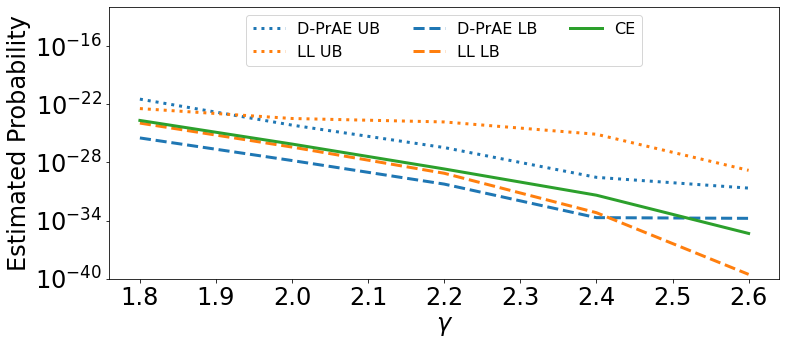

In [18]:
idxs=[16, 17, 18, 19, 20]

plt.figure(figsize=(12, 5))
plt.rcParams["font.size"] = 24

idx=16 #D-UB
plt.plot(gammas_plt, exp_result_plt[:, idx], label=result_labels[idx], c="C0",  linewidth=3, linestyle="dotted")

idx=19 #L-UB
plt.plot(gammas_plt, exp_result_plt[:, idx], label=result_labels[idx],  c="C1", linewidth=3, linestyle="dotted")

idx=17 #D-LB
plt.plot(gammas_plt, exp_result_plt[:, idx], label=result_labels[idx], c="C0",  linewidth=3, linestyle="dashed")

idx=20 #L-LB
plt.plot(gammas_plt, exp_result_plt[:, idx], label=result_labels[idx],  c="C1", linewidth=3, linestyle="dashed")

idx=21 #CE
plt.plot(gammas_plt, exp_result_plt[:, idx], label=result_labels[idx],  c="C2", linewidth=3)

    
plt.legend(fontsize=16, ncol=3, loc=9)
plt.yscale('log')
plt.ylim([1e-40, 1e-12])
plt.xlabel('$\gamma$')
plt.ylabel('Estimated Probability')
plt.show()



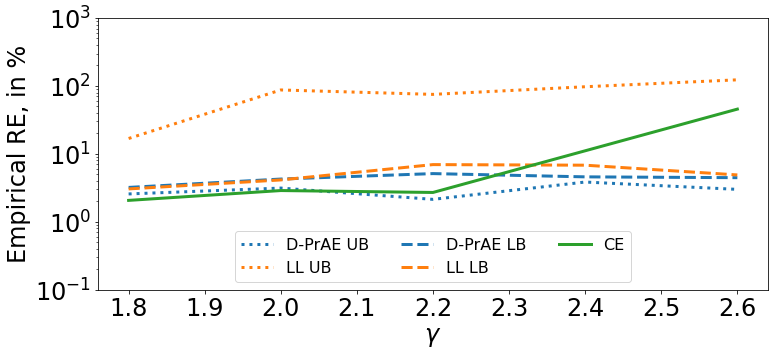

In [19]:
#idxs=[1, 2, 3, 4, 5, 6]
idxs=[8, 9, 10, 11, 12, 13]

plt.figure(figsize=(12, 5))
plt.rcParams["font.size"] = 24

idx=10 #D-UB
plt.plot(gammas_plt, 100*exp_result_plt[:, idx], label="D-PrAE UB", c="C0",  linewidth=3, linestyle="dotted")

idx=12 #L-UB
plt.plot(gammas_plt, 100*exp_result_plt[:, idx], label="LL UB",  c="C1", linewidth=3, linestyle="dotted")

idx=9 #D-LB
plt.plot(gammas_plt, 100*exp_result_plt[:, idx], label="D-PrAE LB", c="C0",  linewidth=3, linestyle="dashed")

idx=13 #L-LB
plt.plot(gammas_plt, 100*exp_result_plt[:, idx], label="LL LB",  c="C1", linewidth=3, linestyle="dashed")

idx=23 #CE
plt.plot(gammas_plt, 100*exp_result_plt[:, idx], label="CE",  c="C2", linewidth=3)

    
plt.legend(loc=8, fontsize=16, ncol=3)
plt.yscale('log')
plt.xlabel('$\gamma$')
plt.ylabel('Empirical RE, in %')
plt.ylim([1e-1, 1e3])
plt.show()
